# Draft_01

**Course:** Advanced Topics in Deep Learning  
**Topic:** Generative Adversarial Networks (GANs)  
**Authors:** António Cruz (140129), Ricardo Kayseller (95813)

## 1. Environment Setup

---

In [1]:
# Import required dependencies
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Set global variables

SEED = 42

DATASET_PATH = "../../dataset/"

BATCH_SIZE = 128
LATENT_DIM = 100
NUM_CLASSES = 10

NUM_STEPS = 15005
SAVE_INTERVAL = 1000

MODEL_OUTPUT_PATH = "model/"
CGAN_MODEL_NAME = "CGAN_DRAFT_01"
D_MODEL_NAME = "D_DRAFT_01"
G_MODEL_NAME = "G_DRAFT_01"

In [3]:
# Set random seeds for reproducibility across both numpy and pytorch
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. MNIST Dataset Loading and Processing

---

In [5]:
# Transform: convert PIL image to tensor (scales [0,255] to [0,1]),
# then normalize to [-1, 1] range using mean=0.5, std=0.5
# Formula: (x - 0.5) / 0.5 = 2x - 1, which maps [0,1] to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset from a local folder
train_dataset = datasets.MNIST(
    root=DATASET_PATH,
    train=True,
    download=False,
    transform=transform
)

# DataLoader handles batching, shuffling, and parallel loading
# drop_last=True discards the final incomplete batch so every batch has exactly BATCH_SIZE samples
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 60000
Batches per epoch: 468


## 3. Generator Model

---

In [6]:
class Generator(nn.Module):

    def __init__(self, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES):

        super().__init__()

        # Embed the class label into a vector of the same size as z
        # Equivalent to Keras Embedding(input_dim=10, output_dim=latent_dim)
        self.label_embedding = nn.Embedding(num_classes, latent_dim)

        # Main sequential network that transforms the conditioned noise into an image
        self.model = nn.Sequential(
            # Dense layer: latent_dim → 128*7*7, same as Keras Dense(128*7*7, activation='relu')
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),

            # Reshape handled via forward(); here we continue from (128, 7, 7)

            # First upsample block: (128, 7, 7) → (128, 14, 14)
            nn.Upsample(scale_factor=2),
            # Conv2D(128, 3, padding='same', activation='relu')
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128, momentum=0.8),

            # Second upsample block: (128, 14, 14) → (128, 28, 28)
            nn.Upsample(scale_factor=2),
            # Conv2D(64, 3, padding='same', activation='relu')
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64, momentum=0.8),

            # Output layer: (64, 28, 28) → (1, 28, 28), tanh maps to [-1, 1]
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Embed the label and multiply element-wise with z (multiplicative conditioning)
        label_embed = self.label_embedding(labels).squeeze(1)  # (batch, latent_dim)
        conditioned = z * label_embed                           # (batch, latent_dim)

        # Pass through the dense layer, then reshape to (batch, 128, 7, 7) for the conv layers
        x = self.model[0](conditioned)  # Linear
        x = self.model[1](x)            # ReLU
        x = x.view(-1, 128, 7, 7)       # Reshape — no Keras equivalent layer needed, just tensor op

        # Pass through the remaining conv/upsample layers
        x = self.model[2:](x)
        return x


# Instantiate and move to device
g_model = Generator().to(device)
print(g_model)

Generator(
  (label_embedding): Embedding(10, 100)
  (model): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (6): Upsample(scale_factor=2.0, mode='nearest')
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (10): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
  )
)


# 4. Discriminator Model

---

In [7]:
class Discriminator(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        
        super().__init__()

        # Embed the class label into a vector of size 28*28 (one full image channel)
        # Equivalent to Keras Embedding(input_dim=10, output_dim=784)
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # Main sequential network that classifies the concatenated input
        self.model = nn.Sequential(
            # Input is (2, 28, 28): image channel + label channel
            # Conv2D(32, 3, stride=2, padding='same') — stride 2 halves spatial dims to 14x14
            nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Second conv block: (32, 14, 14) → (64, 7, 7)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Flatten: (64, 7, 7) → (64*7*7) = (3136)
            nn.Flatten(),

            # Dense(512, activation='relu')
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.25),

            # Output: single probability, sigmoid maps to [0, 1]
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embed label to 784 dims, reshape to a spatial map (1, 28, 28)
        label_embed = self.label_embedding(labels).squeeze(1)   # (batch, 784)
        label_embed = label_embed.view(-1, 1, 28, 28)           # (batch, 1, 28, 28)

        # Concatenate image and label map along channel axis: (1, 28, 28) + (1, 28, 28) → (2, 28, 28)
        # Keras does this with Concatenate(axis=-1) on channels-last; here axis=1 for channels-first
        x = torch.cat([img, label_embed], dim=1)

        return self.model(x)


# Instantiate and move to device
d_model = Discriminator().to(device)
print(d_model)

Discriminator(
  (label_embedding): Embedding(10, 784)
  (model): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.25, inplace=False)
    (10): Linear(in_features=512, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


# 5. CGAN Assembly and Optimizers

---

In [8]:
# Binary cross-entropy loss
criterion = nn.BCELoss()

# Separate optimizers for G and D:
# PyTorch requires explicit optimizer instances tied to each model's parameters
optimizer_g = optim.Adam(g_model.parameters(), lr=0.001)
optimizer_d = optim.Adam(d_model.parameters(), lr=0.001)

# 6. Training

---

Step 0 — D loss: 0.6952, G loss: 0.6185


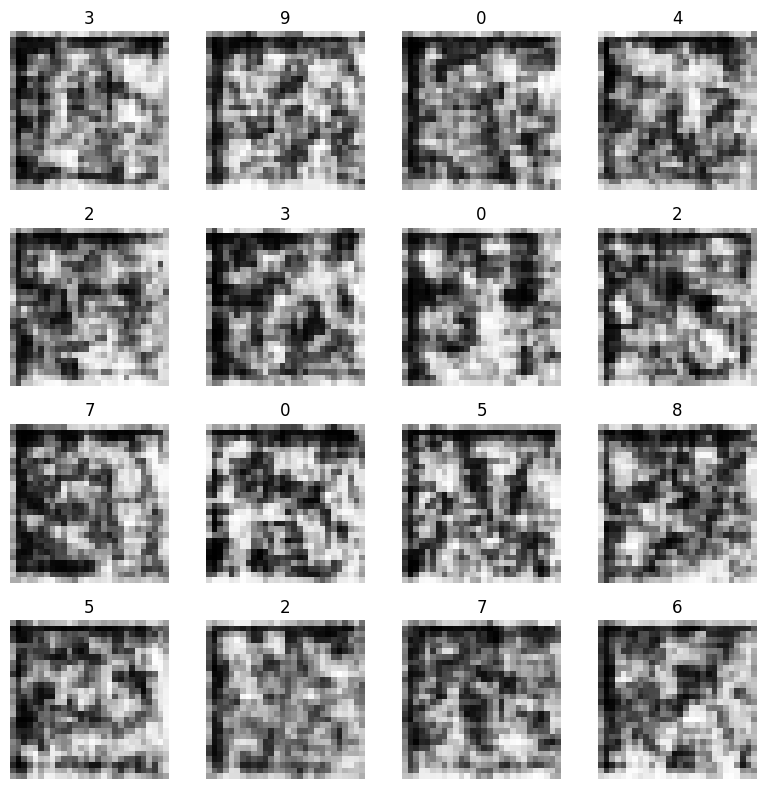

Step 1000 — D loss: 0.4898, G loss: 2.1670


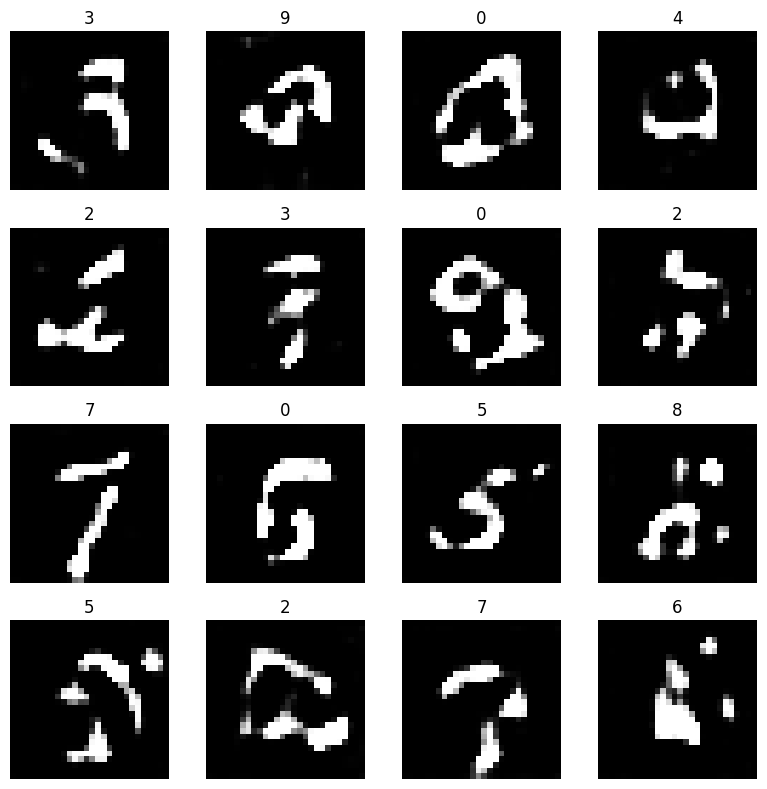

Step 2000 — D loss: 0.5843, G loss: 1.0887


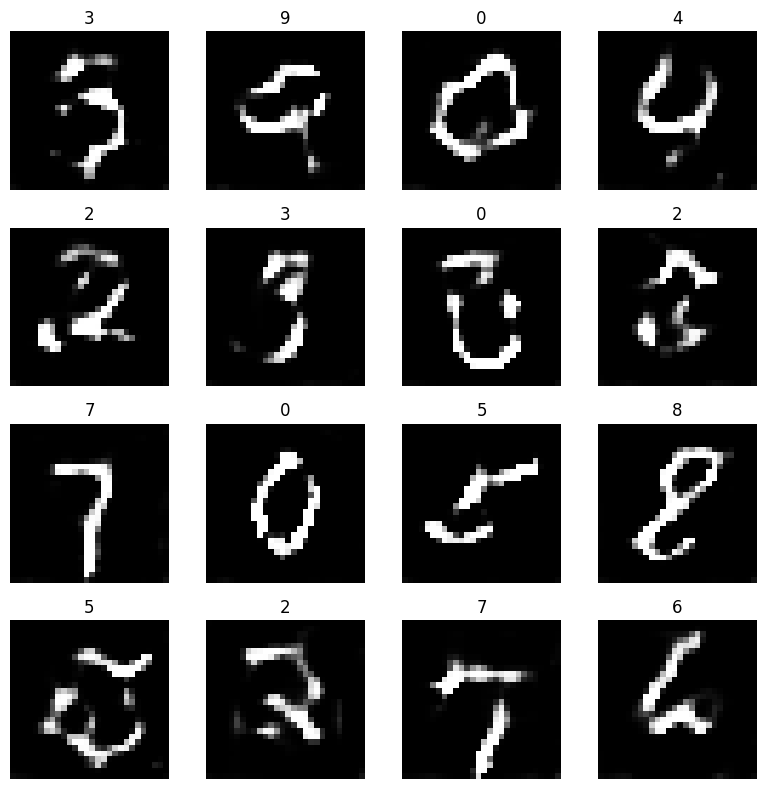

Step 3000 — D loss: 0.5182, G loss: 1.2535


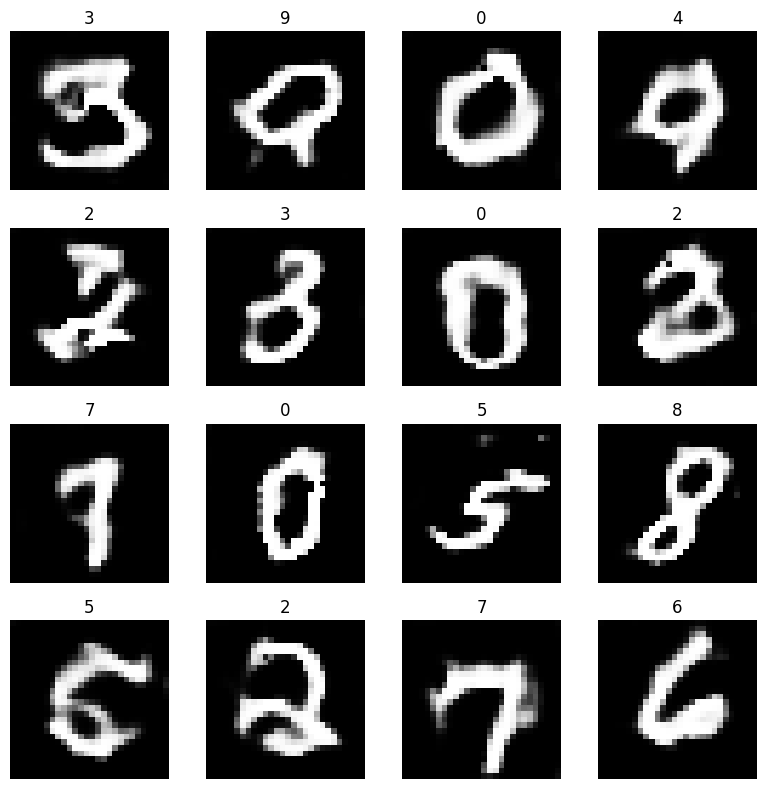

Step 4000 — D loss: 0.5258, G loss: 1.0441


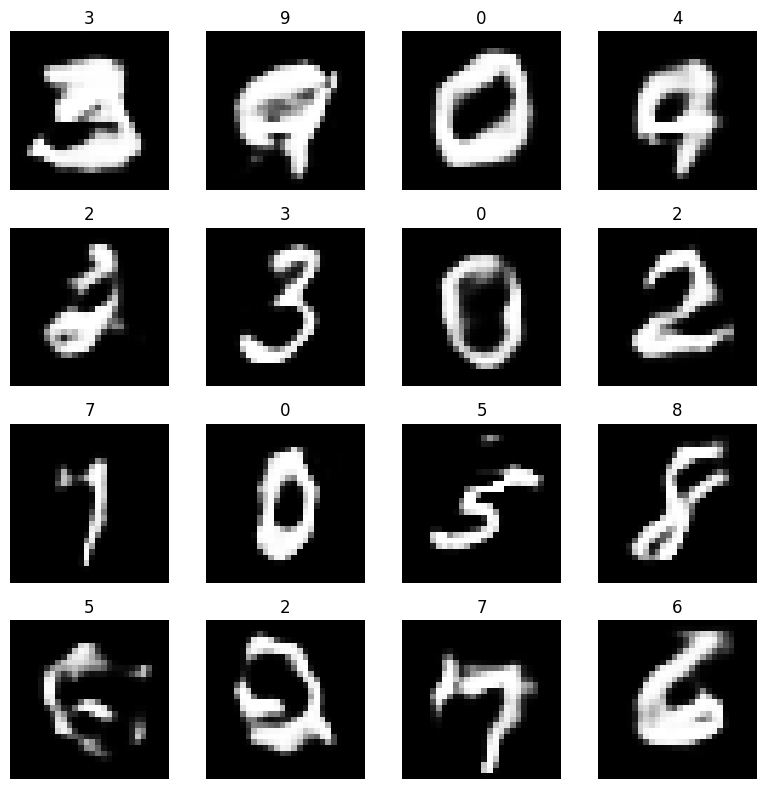

Step 5000 — D loss: 0.5537, G loss: 1.0793


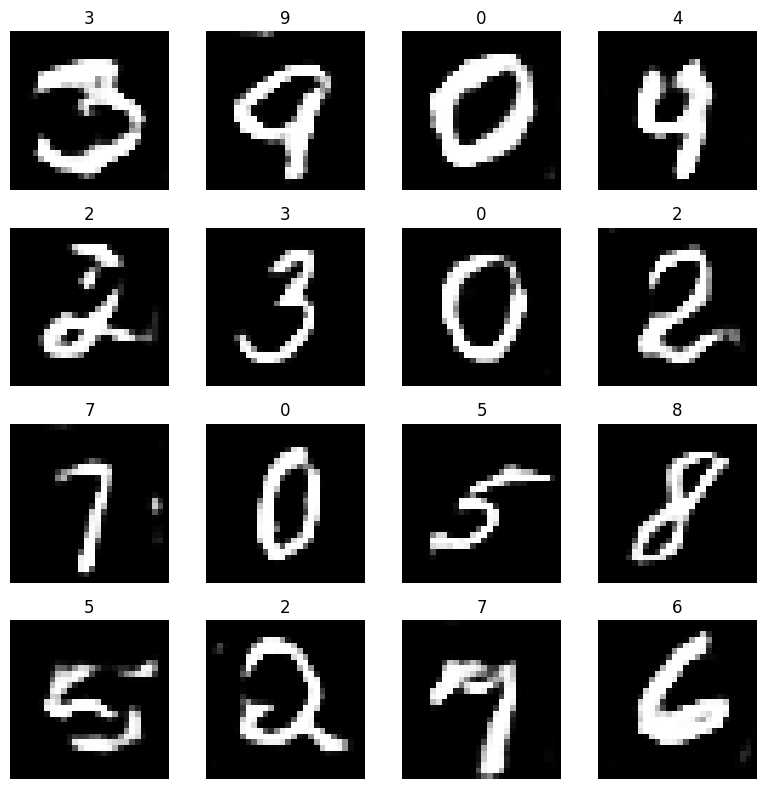

Step 6000 — D loss: 0.6362, G loss: 0.9609


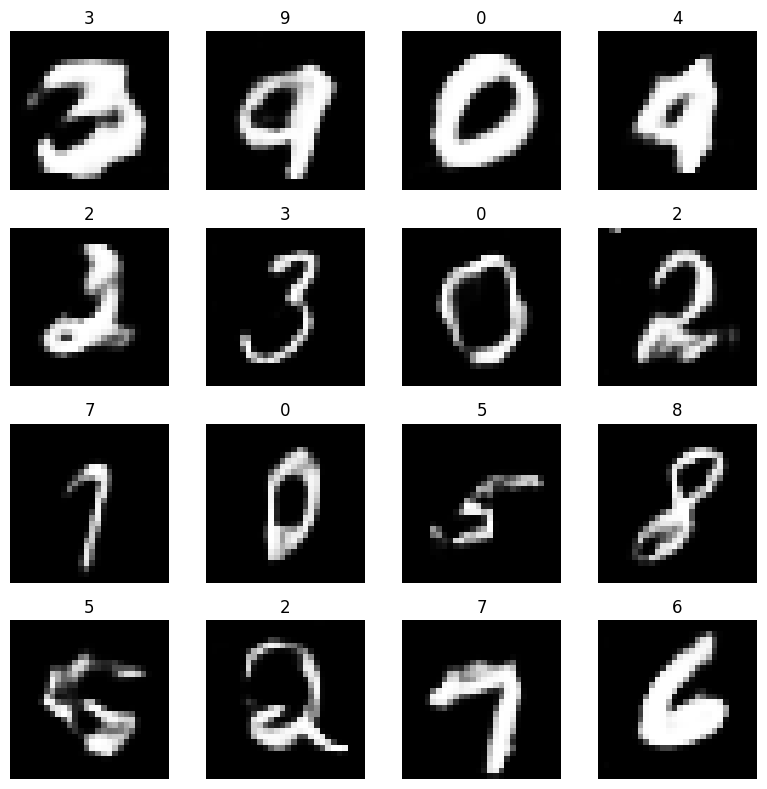

Step 7000 — D loss: 0.6327, G loss: 0.9832


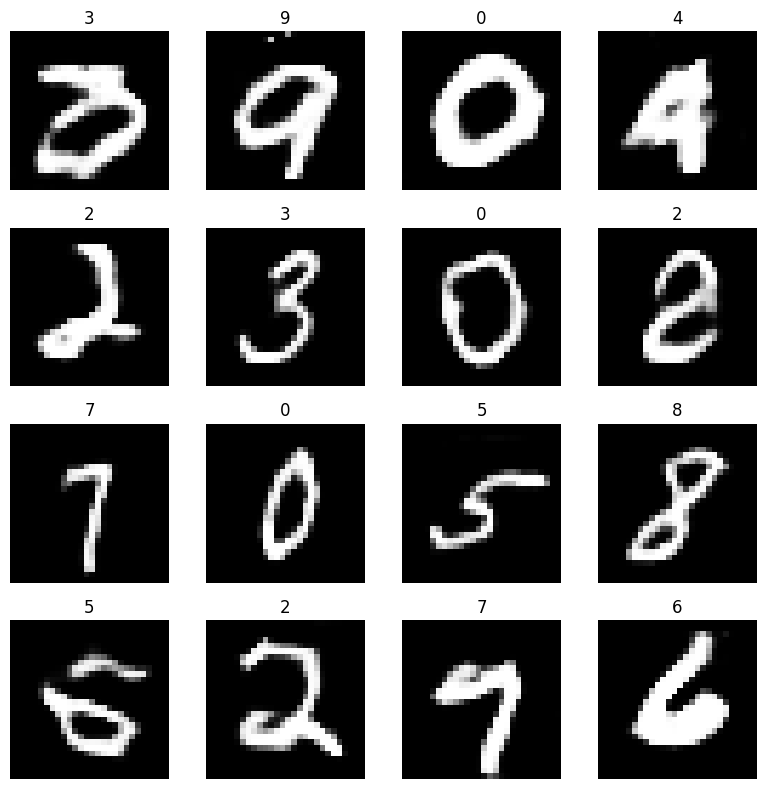

Step 8000 — D loss: 0.6019, G loss: 0.9731


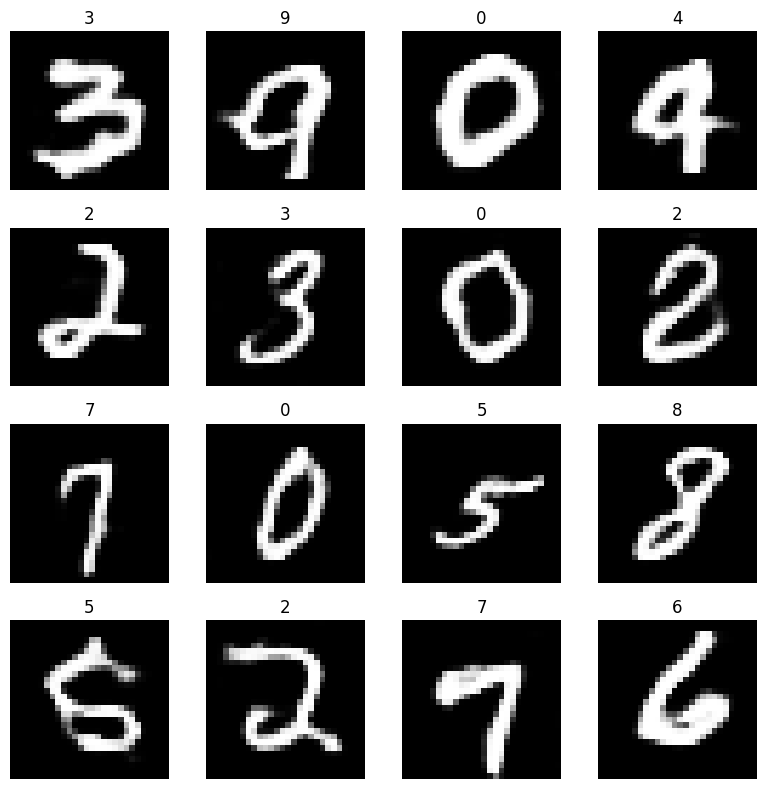

Step 9000 — D loss: 0.6219, G loss: 0.9267


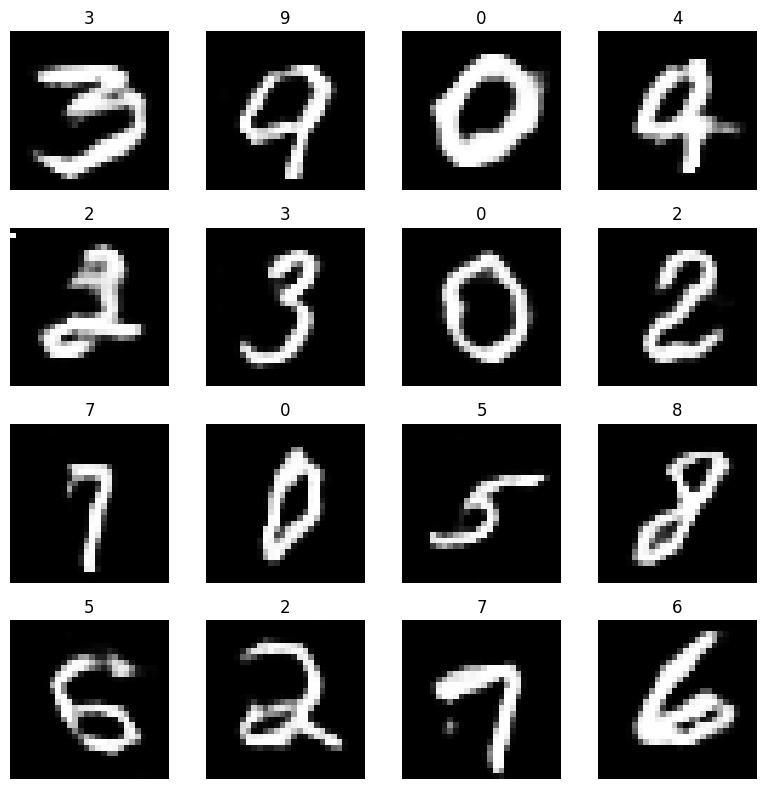

Step 10000 — D loss: 0.6141, G loss: 0.9530


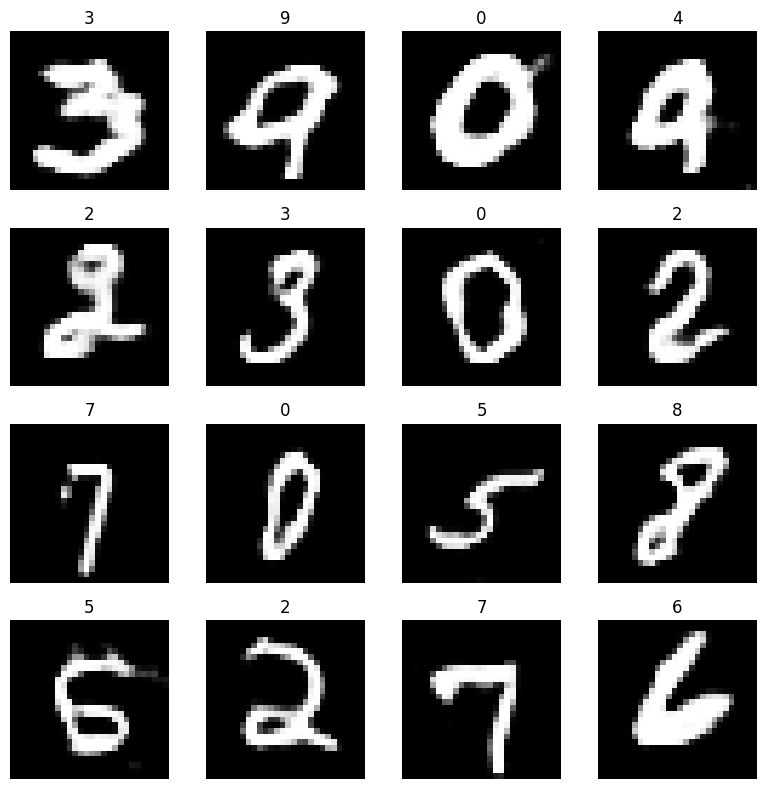

Step 11000 — D loss: 0.6553, G loss: 0.8569


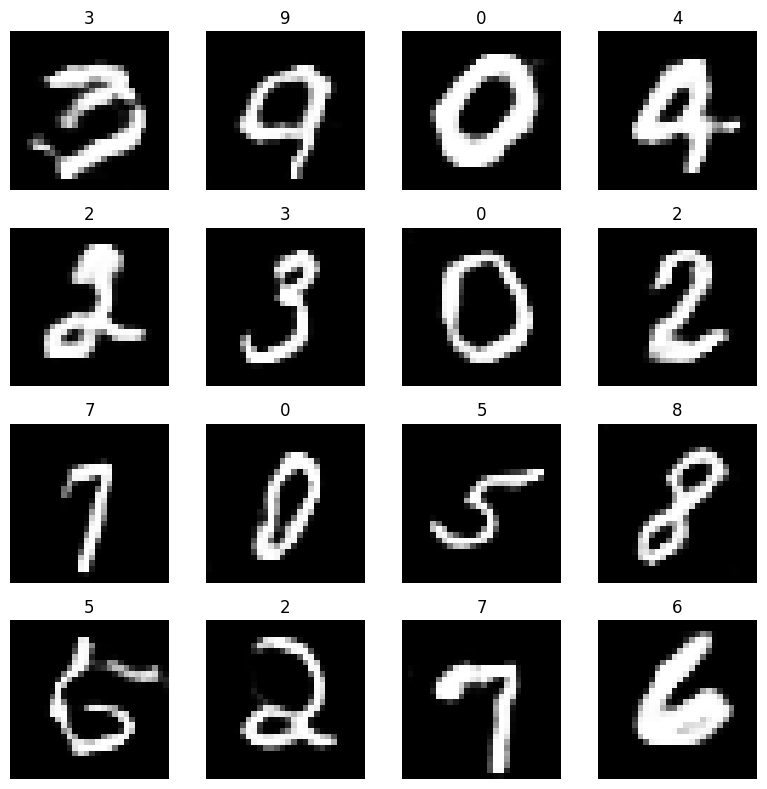

Step 12000 — D loss: 0.5834, G loss: 1.0344


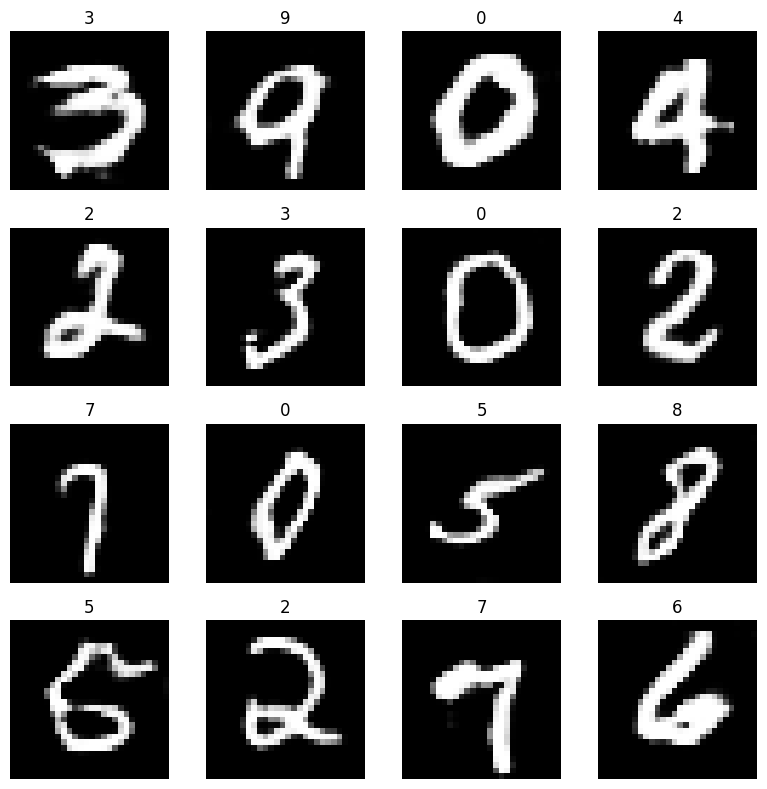

Step 13000 — D loss: 0.6426, G loss: 0.8863


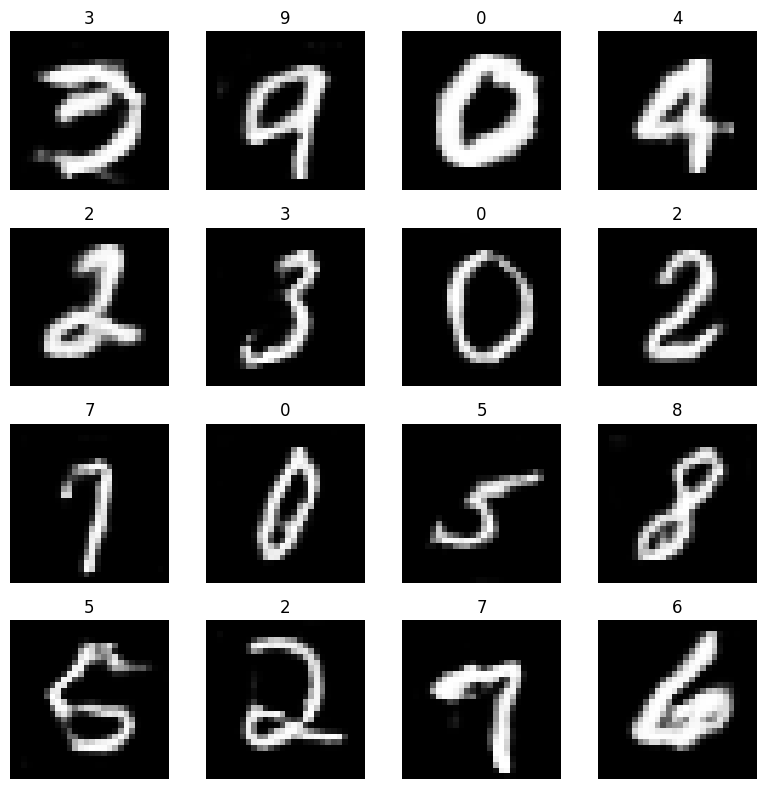

Step 14000 — D loss: 0.5889, G loss: 1.0106


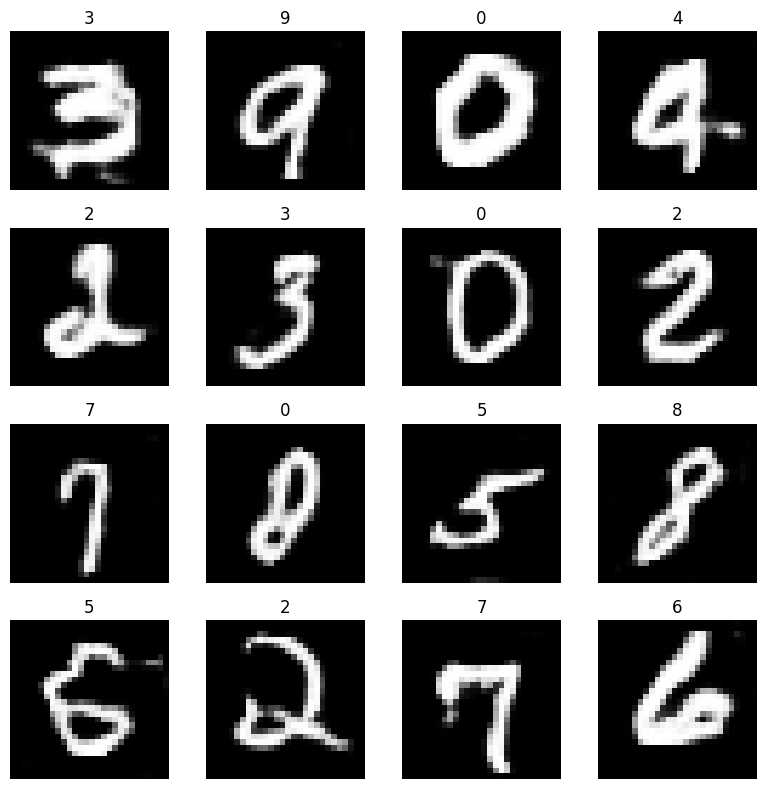

Step 15000 — D loss: 0.6495, G loss: 0.8811


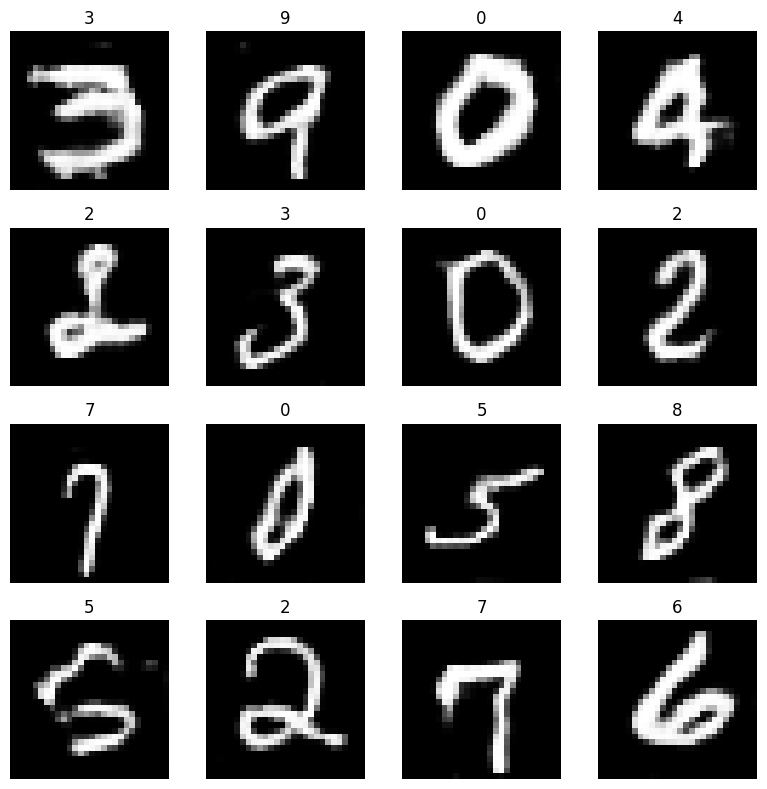

In [9]:
def plot_image(images, labels, rows, cols):
    """Plots a grid of generated images with their class labels."""
    fig = plt.figure(figsize=(8, 8))
    for i in range(rows * cols):
        # Convert from (1, 28, 28) tensor to (28, 28) numpy for matplotlib
        img = images[i].detach().cpu().numpy().reshape(28, 28)
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(str(labels[i].item()))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    fig.tight_layout()
    plt.show()


def train_model():
    # Fixed test noise and labels — used every SAVE_INTERVAL to visualize progress
    # Keeping these fixed means we can see how the same inputs improve over time
    samples_test = torch.randn(16, LATENT_DIM, device=device)
    labels_test = torch.randint(0, 10, (16, 1), device=device)

    losses = {"G": [], "D": []}

    # Label tensors reused every iteration — allocated once for efficiency
    real_labels = torch.ones(BATCH_SIZE, 1, device=device)
    fake_labels = torch.zeros(BATCH_SIZE, 1, device=device)

    for step in range(NUM_STEPS):

        # --- Get a real batch ---
        # The Keras version samples a random batch manually with np.random.randint.
        # Here we do the same for a 1:1 port: pick random indices from the full dataset.
        idx = np.random.randint(0, len(train_dataset), BATCH_SIZE)
        # Stack individual (image, label) tuples into batches
        real_imgs = torch.stack([train_dataset[i][0] for i in idx]).to(device)    # (128, 1, 28, 28)
        batch_labels = torch.tensor([train_dataset[i][1] for i in idx]).unsqueeze(1).to(device)  # (128, 1)

        # --- Generate fake images ---
        noise = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        fake_imgs = g_model(noise, batch_labels)

        # --- Train Discriminator ---
        optimizer_d.zero_grad()

        # D loss on real images — should output 1
        d_real_out = d_model(real_imgs, batch_labels)
        d_loss_real = criterion(d_real_out, real_labels)

        # D loss on fake images — should output 0
        # .detach() stops gradients from flowing back into G during D's update
        d_fake_out = d_model(fake_imgs.detach(), batch_labels)
        d_loss_fake = criterion(d_fake_out, fake_labels)

        # Average of real and fake losses, same as the Keras version
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        optimizer_d.step()

        # --- Train Generator ---
        optimizer_g.zero_grad()

        # Fresh noise and random labels for G training, same as the Keras version
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        gen_labels = torch.randint(0, 10, (BATCH_SIZE, 1), device=device)

        # Generate images and ask D to evaluate them
        gen_imgs = g_model(z, gen_labels)
        g_out = d_model(gen_imgs, gen_labels)

        # G wants D to output 1 (think the fakes are real)
        g_loss = criterion(g_out, real_labels)
        g_loss.backward()
        optimizer_g.step()

        # --- Logging ---
        losses["G"].append(g_loss.item())
        losses["D"].append(d_loss.item())

        # Logging
        if step % SAVE_INTERVAL == 0:
            print(f"Step {step} — D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")
            # Generate images from the fixed test noise to track visual progress
            with torch.no_grad():
                results = g_model(samples_test, labels_test)
            plot_image(results, labels_test, 4, 4)

    return losses


losses = train_model()

# 7. Save

---

In [10]:
def save_models():
    """Saves generator and discriminator state dicts."""
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

    # torch.save() serializes the state_dict (all learned parameters)
    # This is the recommended way to save in PyTorch (saving the full model object)
    torch.save(g_model.state_dict(), os.path.join(MODEL_OUTPUT_PATH, f'{G_MODEL_NAME}.pt'))
    torch.save(d_model.state_dict(), os.path.join(MODEL_OUTPUT_PATH, f'{D_MODEL_NAME}.pt'))
    print("Models saved.")

save_models()

Models saved.


# 8. Inference

---

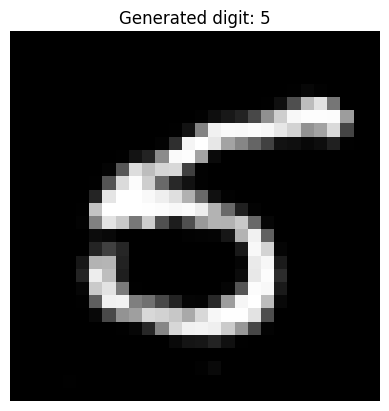

In [11]:
# Specify a digit from 0-9
digit = 5

# Generate a single image for the chosen digit
z = torch.randn(1, LATENT_DIM, device=device)
label = torch.tensor([[digit]], device=device)

# No gradient tracking needed during inference
with torch.no_grad():
    generated = g_model(z, label)

# Convert from (1, 1, 28, 28) GPU tensor to (28, 28) numpy array for plotting
img = generated[0].cpu().numpy().reshape(28, 28)
plt.imshow(img, cmap='gray')
plt.title(f"Generated digit: {digit}")
plt.axis('off')
plt.show()